# Facies classification using Machine Learning- Logistic regression

Contest entry by Priyanka Raghavan and Steve Hall

This notebook demonstrates how to train a machine learning algorithm to predict facies from well log data.  The dataset we will use comes from a class excercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset we will use is log data from nine wells that have been labeled with a facies type based on oberservation of core.  We will use this log data to train a Logistical regression classifier to classify facies types.  We will use simple logistics regression to classify wells [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

First we will [explore the dataset](#Exploring-the-dataset).  We will load the training data from 9 wells, and take a look at what we have to work with.  We will plot the data from a couple wells, and create cross plots to look at the variation within the data.  

Next we will [condition the data set](#Conditioning-the-data-set).  We will remove the entries that have incomplete data.  The data will be scaled to have zero mean and unit variance.  We will also split the data into training and test sets.

We will then be ready to [build the classifier](#Training-the-classifier-using-Logistics-Regression).  

Finally, once we have a built and tuned the classifier, we can [apply the trained model](#Applying-the-classification-model-to-new-data) to classify facies in wells which do not already have labels.  We will apply the classifier to two wells, but in principle you could apply the classifier to any number of wells that had the same log data.

## Exploring the dataset

First, we will examine the data set we will use to train the classifier.  The training data is contained in the file `facies_vectors.csv`.  The dataset consists of 5 wireline log measurements, two indicator variables and a facies label at half foot intervals.  In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type).  We will use the pandas library to load the data into a dataframe, which provides a convenient data structure to work with well log data.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = '../facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

In [3]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

In [4]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


This is a quick view of the statistical distribution of the input variables.  Looking at the `count` values, there are 3232 feature vectors in the training set.

Remove a single well to use as a blind test later.

In [5]:
blind = training_data[training_data['Well Name'] == 'SHANKLE']
training_data = training_data[training_data['Well Name'] != 'SHANKLE']

These are the names of the 10 training wells in the Council Grove reservoir.  Data has been recruited into pseudo-well 'Recruit F9' to better represent facies 9, the Phylloid-algal bafflestone. 

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial.  We also create the abbreviated facies labels, and add those to the `facies_vectors` dataframe.

In [6]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

Let's take a look at the data from individual wells in a more familiar log plot form.  We will create plots for the five well log variables, as well as a log for facies labels.  The plots are based on the those described in Alessandro Amato del Monte's [excellent tutorial](https://github.com/seg/tutorials/tree/master/1504_Seismic_petrophysics_1).

In [7]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

Placing the log plotting code in a function will make it easy to plot the logs from multiples wells, and can be reused later to view the results when we apply the facies classification model to other wells.  The function was written to take a list of colors and facies labels as parameters.  

We then show log plots for wells `SHRIMPLIN`.  

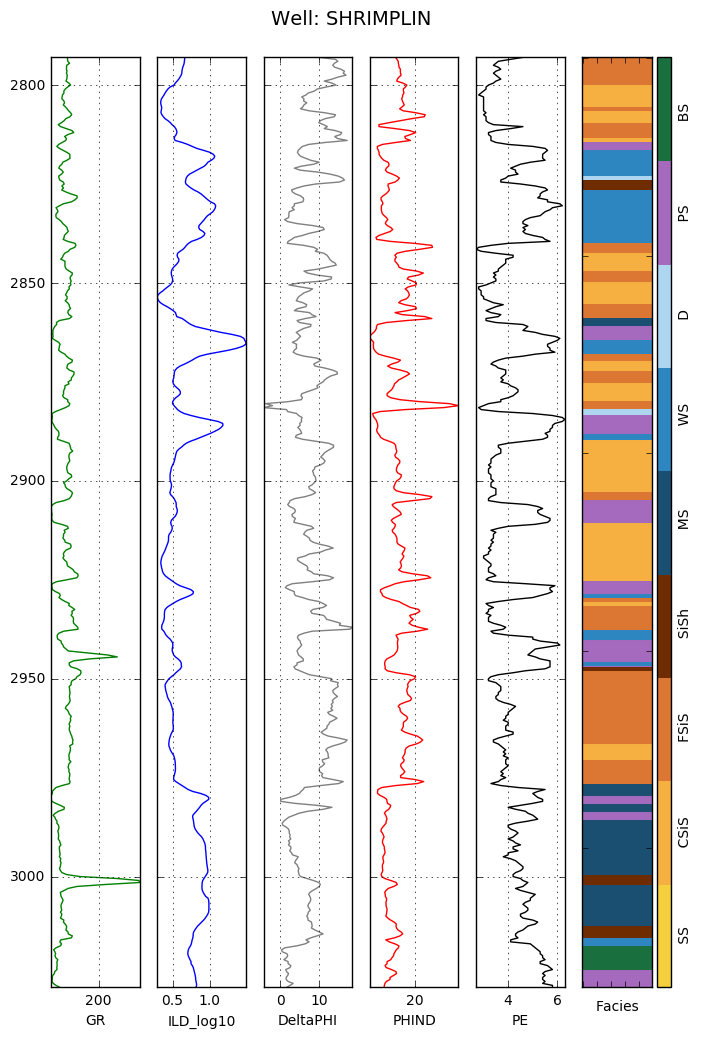

In [8]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histogram of the number of training examples for each facies class.

SS      179
CSiS    851
FSiS    663
SiSh    264
MS      277
WS      511
D       124
PS      646
BS      185
Name: Facies, dtype: int64

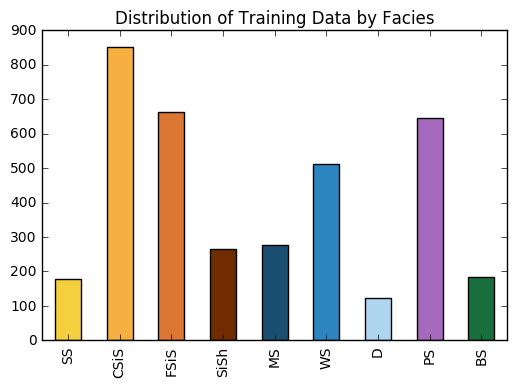

In [9]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

This shows the distribution of examples by facies for the examples in the training set.  Dolomite (facies 7) has the fewest with 81 examples.  Depending on the performance of the classifier we are going to train, we may consider getting more examples of these facies.

Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type.  This dataset contains 5 log variables, and scatter matrix can help to quickly visualize the variation between the all the variables in the dataset.  We can employ the very useful [Seaborn library](https://stanford.edu/~mwaskom/software/seaborn/) to quickly create a nice looking scatter matrix. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies.  The same colormap is used to represent the 9 facies.  

ValueError: max must be larger than min in range parameter.

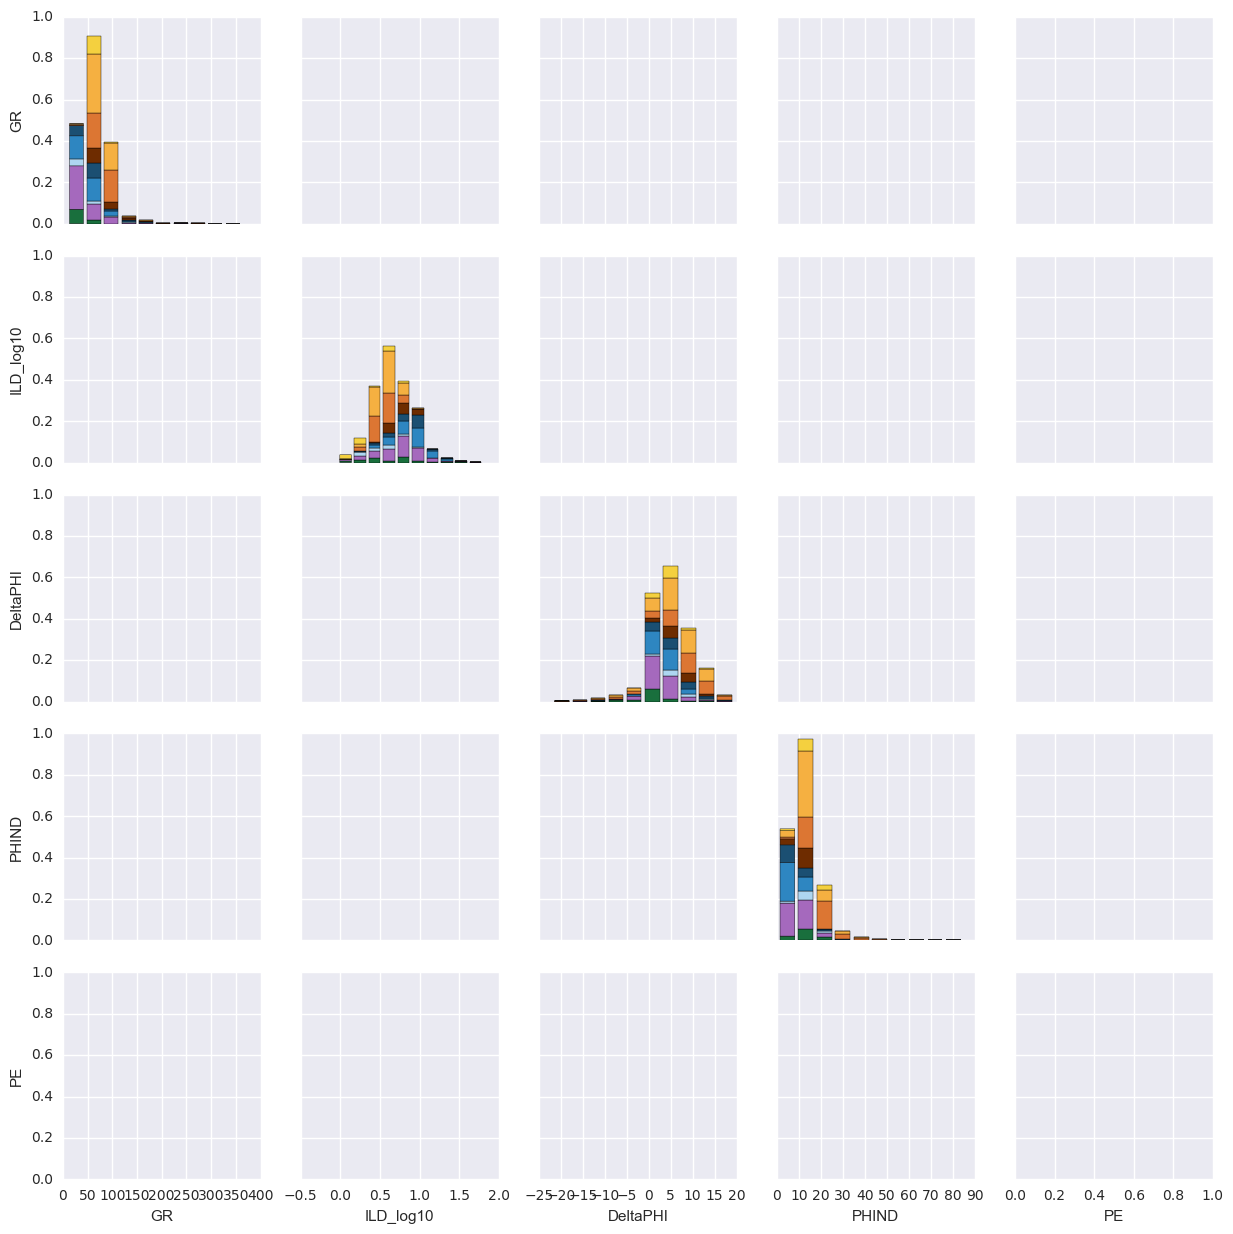

In [10]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

## Conditioning the data set

Now we extract just the feature variables we need to perform the classification.  The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

In [ ]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

Scikit includes a [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) module that can 'standardize' the data (giving each variable zero mean and unit variance, also called *whitening*).  Many machine learning algorithms assume features will be standard normally distributed data (ie: Gaussian with zero mean and unit variance).  The factors used to standardize the training set must be applied to any subsequent feature set that will be input to the classifier.  The `StandardScalar` class can be fit to the training set, and later used to standardize any training data.

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [ ]:
feature_vectors

Scikit also includes a handy function to randomly split the training data into training and test sets.  The test set contains a small subset of feature vectors that are not used to train the network.  Because we know the true facies labels for these examples, we can compare the results of the classifier to the actual facies and determine the accuracy of the model.  Let's use 20% of the data for the test set.

In [ ]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.1, random_state=42)

## Training the classifier using Logistic Regression

Now we use the cleaned and conditioned training set to create a facies classifier.  As mentioned above, we will use a type of machine learning model known as a [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression).  For our test we used the one vs rest and sag solver as data has already been scaled. 
 

In [ ]:
from sklearn import linear_model
clf = linear_model.LogisticRegression(class_weight='balanced',multi_class='ovr',solver='sag',max_iter=1000,random_state=40,C=1e5)


Now we can train the classifier using the training set we created above.

In [ ]:
clf.fit(X_train,y_train)

Now that the model has been trained on our data, we can use it to predict the facies of the feature vectors in the test set.  

In [ ]:
predicted_labels = clf.predict(X_test)

We need some metrics to evaluate how good our classifier is doing.  A [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) is a table that can be used to describe the performance of a classification model.  [Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) allows us to easily create a confusion matrix by supplying the actual and predicted facies labels.

The confusion matrix is simply a 2D array.  The entries of confusion matrix `C[i][j]` are equal to the number of observations predicted to have facies `j`, but are known to have facies `i`.  

To simplify reading the confusion matrix, a function has been written to display the matrix along with facies labels and various error metrics.  See the file `classification_utilities.py` in this repo for the `display_cm()` function.

In [ ]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, hide_zeros=True)

The rows of the confusion matrix correspond to the actual facies labels.  The columns correspond to the labels assigned by the classifier.  For example, consider the first row. For the feature vectors in the test set that actually have label `SS`, 18 were correctly indentified as `SS`, 5 were classified as `CSiS` and 1 was classified as `FSiS`.

The entries along the diagonal are the facies that have been correctly classified.  Below we define two functions that will give an overall value for how the algorithm is performing.  The accuracy is defined as the number of correct classifications divided by the total number of classifications.

In [ ]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

As noted above, the boundaries between the facies classes are not all sharp, and some of them blend into one another.  The error within these 'adjacent facies' can also be calculated.  We define an array to represent the facies adjacent to each other.  For facies label `i`, `adjacent_facies[i]` is an array of the adjacent facies labels.

In [ ]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [ ]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

## Applying the classification model to the blind data

We held a well back from the training, and stored it in a dataframe called `blind`:

In [ ]:
blind

The label vector is just the `Facies` column:

In [ ]:
y_blind = blind['Facies'].values

We can form the feature matrix by dropping some of the columns and making a new dataframe:

In [ ]:
well_features = blind.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)

Now we can transform this with the scaler we made before:

In [ ]:
X_blind = scaler.transform(well_features)

Now it's a simple matter of making a prediction and storing it back in the dataframe:

In [ ]:
y_pred = clf.predict(X_blind)
blind['Prediction'] = y_pred

Let's see how we did with the confusion matrix:

In [ ]:
cv_conf = confusion_matrix(y_blind, y_pred)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

The results are 0.59 accuracy on facies classification of blind data and 0.92 adjacent facies classification.

In [ ]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

...but does remarkably well on the adjacent facies predictions. 

In [ ]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

In [ ]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [ ]:
compare_facies_plot(blind, 'Prediction', facies_colors)

## Applying the classification model to new data

Now that we have a trained facies classification model we can use it to identify facies in wells that do not have core data.  In this case, we will apply the classifier to two wells, but we could use it on any number of wells for which we have the same set of well logs for input.

This dataset is similar to the training data except it does not have facies labels.  It is loaded into a dataframe called `test_data`.

In [ ]:
well_data = pd.read_csv('../validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)

The data needs to be scaled using the same constants we used for the training data.

In [ ]:
X_unknown = scaler.transform(well_features)

Finally we predict facies labels for the unknown data, and store the results in a `Facies` column of the `test_data` dataframe.

In [ ]:
#predict facies of unclassified data
y_unknown = clf.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data

In [ ]:
well_data['Well Name'].unique()

We can use the well log plot to view the classification results along with the well logs.

In [ ]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    well_data[well_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)

Finally we can write out a csv file with the well data along with the facies classification results.

In [ ]:
well_data.to_csv('SHPR_FirstAttempt_LogisticsRegression_facies.csv')

## References

Amato del Monte, A., 2015. Seismic Petrophysics: Part 1, *The Leading Edge*, 34 (4). [doi:10.1190/tle34040440.1](http://dx.doi.org/10.1190/tle34040440.1)

Bohling, G. C., and M. K. Dubois, 2003. An Integrated Application of Neural Network and Markov Chain Techniques to Prediction of Lithofacies from Well Logs, *KGS Open-File Report* 2003-50, 6 pp. [pdf](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf)

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem, *Computers & Geosciences*, 33 (5), 599-617 pp. [doi:10.1016/j.cageo.2006.08.011](http://dx.doi.org/10.1016/j.cageo.2006.08.011)